In [1]:
!pip install yahoo_fin

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt

In [3]:
N_STEPS = 7

LOOKUP_STEPS = [1, 2, 3]

STOCK = 'GOOGL'

date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [10]:
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [11]:
init_df

,open,high,low,close,adjclose,volume,ticker
2020-10-22,79.250000,80.670998,78.874001,80.333000,80.333000,30512000,GOOGL
2020-10-23,80.752502,81.706001,80.595497,81.649002,81.649002,30548000,GOOGL
2020-10-26,80.750000,81.478996,78.389000,79.214500,79.214500,35826000,GOOGL
2020-10-27,79.446503,80.099998,78.849503,79.944000,79.944000,25902000,GOOGL
2020-10-28,77.500504,77.690498,75.424004,75.540001,75.540001,45174000,GOOGL
...,...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300,GOOGL
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200,GOOGL
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100,GOOGL
2023-10-27,122.879997,123.309998,120.209999,122.169998,122.169998,44531100,GOOGL


In [12]:
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
init_df['date'] = init_df.index

In [13]:
init_df

,close,date
2020-10-22,80.333000,2020-10-22
2020-10-23,81.649002,2020-10-23
2020-10-26,79.214500,2020-10-26
2020-10-27,79.944000,2020-10-27
2020-10-28,75.540001,2020-10-28
...,...,...
2023-10-24,138.809998,2023-10-24
2023-10-25,125.610001,2023-10-25
2023-10-26,122.279999,2023-10-26
2023-10-27,122.169998,2023-10-27


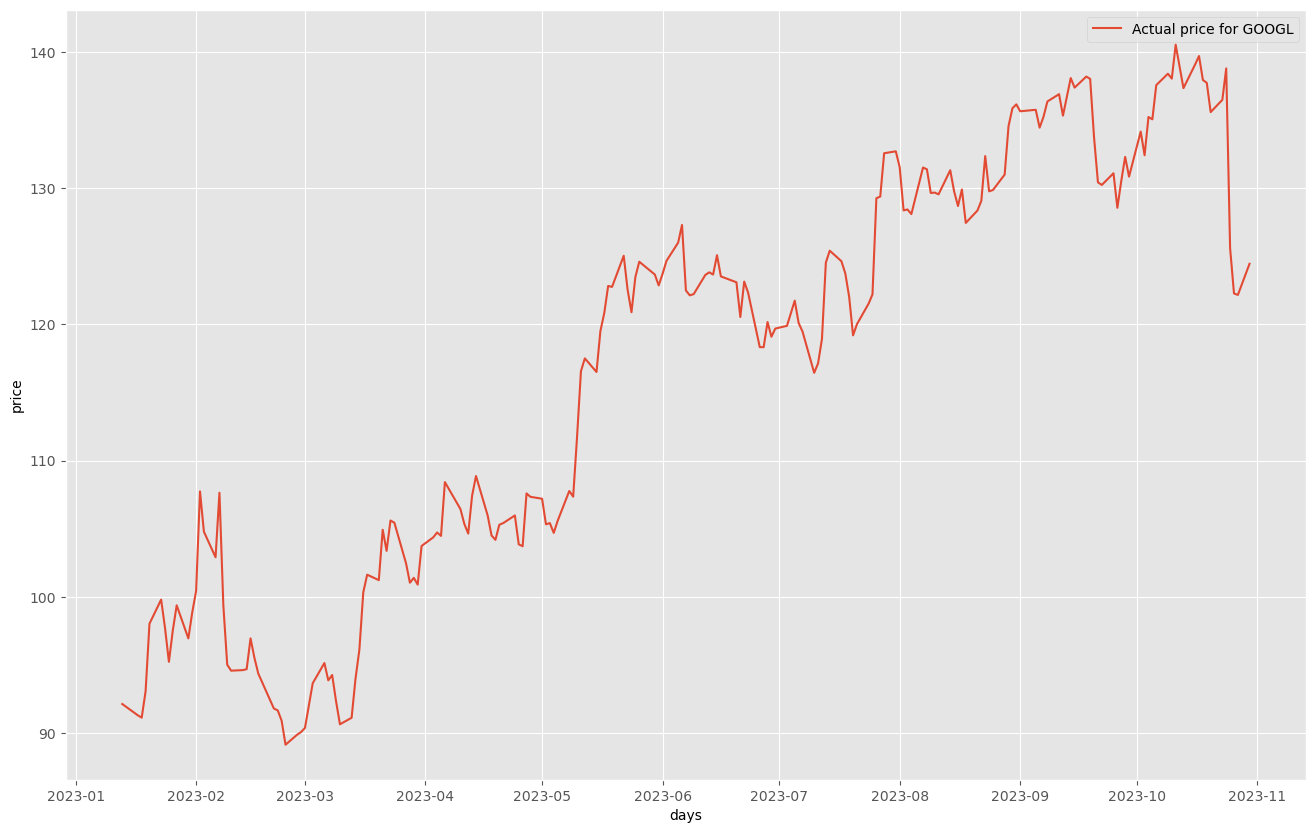

In [14]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [15]:
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [16]:
init_df

,close,date,scaled_close
2020-10-22,80.333000,2020-10-22,0.064510
2020-10-23,81.649002,2020-10-23,0.082222
2020-10-26,79.214500,2020-10-26,0.049456
2020-10-27,79.944000,2020-10-27,0.059274
2020-10-28,75.540001,2020-10-28,0.000000
...,...,...,...
2023-10-24,138.809998,2023-10-24,0.851565
2023-10-25,125.610001,2023-10-25,0.673903
2023-10-26,122.279999,2023-10-26,0.629084
2023-10-27,122.169998,2023-10-27,0.627603


In [17]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [18]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2020-10-22   80.333000 2020-10-22      0.064510  0.059274
 2020-10-23   81.649002 2020-10-23      0.082222  0.000000
 2020-10-26   79.214500 2020-10-26      0.049456  0.031010
 2020-10-27   79.944000 2020-10-27      0.059274  0.070869
 2020-10-28   75.540001 2020-10-28      0.000000  0.076395
 ...                ...        ...           ...       ...
 2023-10-19  137.750000 2023-10-19      0.837298  0.851565
 2023-10-20  135.600006 2023-10-20      0.808361  0.673903
 2023-10-23  136.500000 2023-10-23      0.820474  0.629084
 2023-10-24  138.809998 2023-10-24      0.851565  0.627603
 2023-10-25  125.610001 2023-10-25      0.673903  0.658425
 
 [757 rows x 4 columns],
 array([[0.86381286],
        [0.8401247 ],
        [0.83729815],
        [0.80836093],
        [0.82047415],
        [0.85156494],
        [0.6739032 ],
        [0.629084  ],
        [0.6276035 ],
        [0.6584251 ]], dtype=float32),
 array([[[0.0645100407631478

In [19]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [20]:
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 7s 11ms/step - loss: 0.0164
Epoch 2/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0071
Epoch 3/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 4/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0046
Epoch 5/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 6/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0046
Epoch 7/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0041
Epoch 8/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0037
Epoch 9/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0034
Epoch 10/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0037
Epoch 11/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0034
Epoch 12/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0032
Epoch 13/80
95/95 [==================

94/94 [==============================] - 1s 8ms/step - loss: 0.0051
Epoch 7/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0048
Epoch 8/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 9/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0045
Epoch 10/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0041
Epoch 11/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0040
Epoch 12/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0043
Epoch 13/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0038
Epoch 14/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0047
Epoch 15/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0038
Epoch 16/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0040
Epoch 17/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 18/80
94/94 [==============================] - 1s

94/94 [==============================] - 1s 10ms/step - loss: 0.0052
Epoch 13/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0048
Epoch 14/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 15/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 16/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0051
Epoch 17/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 18/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0044
Epoch 19/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0048
Epoch 20/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0043
Epoch 21/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 22/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0043
Epoch 23/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0044
Epoch 24/80
94/94 [=====================

In [21]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
  
  print(message)

GOOGL prediction for upcoming 3 days (124.95$, 123.35$, 125.64$)


In [22]:
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 5ms/step


In [23]:
copy_df

,close,date,scaled_close,predicted_close
2020-10-22,80.333000,2020-10-22,0.064510,87.292503
2020-10-23,81.649002,2020-10-23,0.082222,88.125000
2020-10-26,79.214500,2020-10-26,0.049456,87.986504
2020-10-27,79.944000,2020-10-27,0.059274,88.070999
2020-10-28,75.540001,2020-10-28,0.000000,86.886002
...,...,...,...,...
2023-10-24,138.809998,2023-10-24,0.851565,139.482971
2023-10-25,125.610001,2023-10-25,0.673903,131.397186
2023-10-26,122.279999,2023-10-26,0.629084,122.279999
2023-10-27,122.169998,2023-10-27,0.627603,122.169998


In [24]:
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

C:\Users\chand\AppData\Local\Temp\ipykernel_9688\1868845331.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
C:\Users\chand\AppData\Local\Temp\ipykernel_9688\1868845331.py:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]


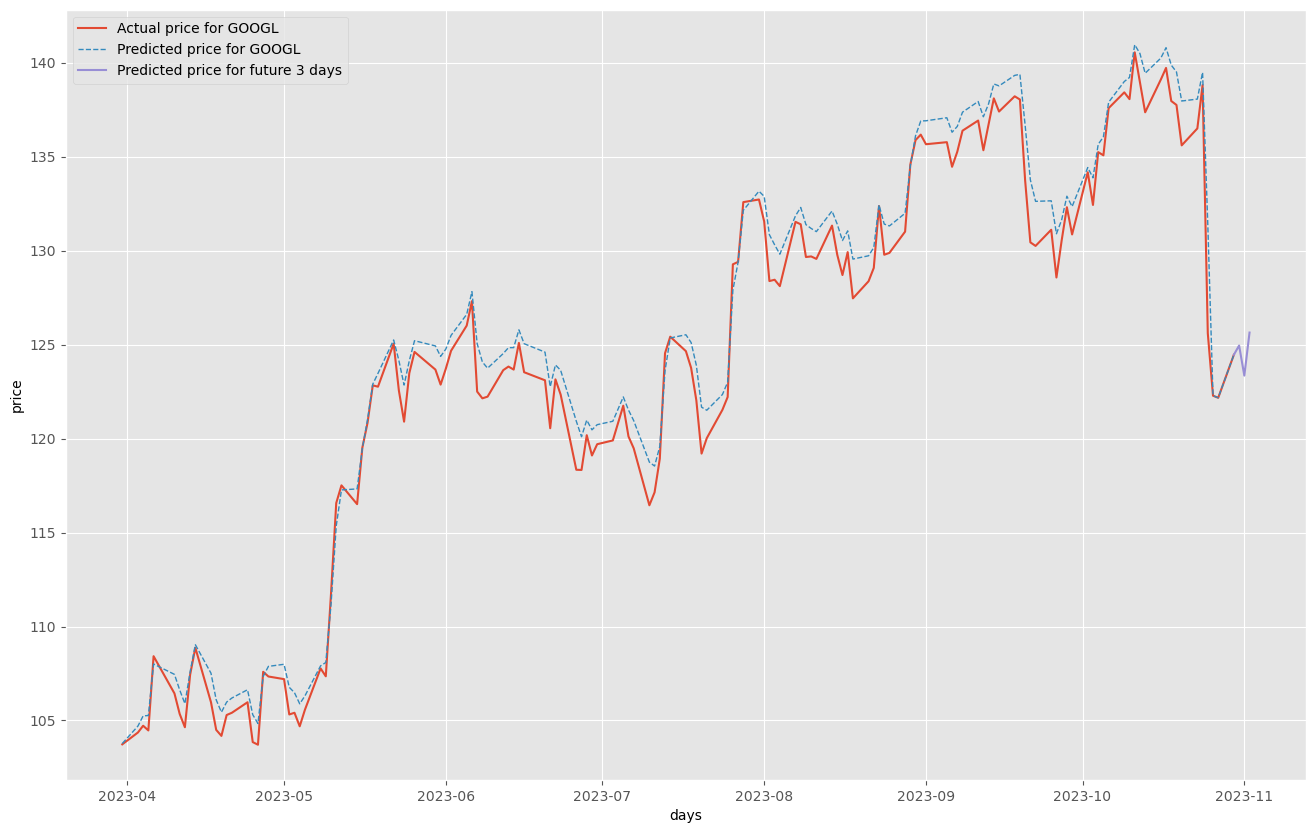

In [25]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()